# CS 146 : LBA
## Isaac Schaal

In [121]:
import numpy as np
import pandas as pd
import difflib
import matplotlib.pyplot as plt
%matplotlib inline
import pystan
from scipy import stats
plt.style.use('ggplot')

## Loading and Cleaning the Data

I first downloaded the data from the results google sheet, and then uploaded it. I also downloaded the locations assignments sheet, as there was a neighborhood tied to each location.

In [109]:
# Load the data
data = pd.read_csv('store_data.csv')

# Load the location.csv, which is the spreadsheet
# of assigned stores and locations
locs = pd.read_csv('location.csv', header = 3, usecols=[2,5])
locs = locs.dropna()
locs = locs.reset_index()

# Create a dictionary that maps locations to Neighborhoods
locs_dic = {}
for i in range(len(locs)):
    locs_dic[locs.Supermarket[i]] = locs.Neighborhood[i]

## Neighborhoods

My first act of cleaning was simplifying the location to be by neighborhood. There were too many individual locations and each was only visited once, so in order to see trends accross them, I grouped them into neighborhoods. 

In [110]:
manual = []
replace = []

#Go through each store address and, using difflib to get the 
#closest string from those that users inputted, and add the 
# correct neighborhood. Some were inputted incorrectly 
# or were from London or Capetown, and these were handled manually

for i in range(len(data['Grocery store street address'])):
    location = data['Grocery store street address'][i]
    # Gets the closest match, with output being a list
    match = difflib.get_close_matches(location, locs.Supermarket)
    # If the list is len 0 there was no match
    if  len(match) == 0:
        manual.append((location,i))
        replace.append(location)
    # Take the closest match
    else:
        replace.append(locs_dic[match[0]])

manual_correct = ['Kreuzberg','Mitte','London','London','London','Mitte',
'Neukölln','London','London','London','London','London',
 'Kreuzberg','Lichtenberg','Cape Town', 'Cape Town',
 'Mitte','London','London', 'London'
]

for i in range(len(manual)):
    replace[manual[i][1]] = manual_correct[i]
    
# Replace the locations with the correct neighborhoods list      
data['Grocery store street address'] = replace

## Formatting

I next had to create a new dataframe, which was mostly reformatting the first. The data from students had each store as one row, with all products in a row. I wanted a dataframe that had one product per row, with the associated store, brand, location and price. I accomplished this with a triple nested for loop.

In [111]:
data_len = 80
product_names = ['Apple', 'Bananas', 'Tomatoes',
                'Potatoes', 'Flour', 'Rice',
                'Milk','Butter','Eggs',
                'Chicken breasts']

# Create a new data frame, as currently there
# are multiple products per row
# The format of the new data frame is 
# [product, Store Brand, location, Product Brand, Price]
lis = []
for i in range(10):
    for j in range(data_len):
        for k in range(3):
            #Account for missing data values
            if not np.isnan(data.iloc[:,4+6*i+k*2+1][j]): 
                lis.append(
                    [product_names[i], # Product
                    data.iloc[:,2][j], # Store Brand
                    data.iloc[:,3][j], # Store Location
                    data.iloc[:,4+6*i+k*2][j], #Product Brand 
                    data.iloc[:,4+6*i+k*2+1][j] # Price
                    ])

# Create a dataframe and correct the names
products = pd.DataFrame(lis)
products.columns = ['product', 'store', 'address', 'brand', 'price']
# Fill the nas with 'no brand'
products.brand = products.brand.fillna( 'no brand')

# Create a new data frame for the cleaned data
cleaned = pd.DataFrame(products)

## Brands

The data cleaning for brands was extensive. Many people did not put the brand, but instead the product itself or the size of the product (operating in a foriegn country is hard). Moreover, even those who did input the brand spelled them in an astonishing number of ways. My approach for dealing with this was as follows. I manually looked through the data and found all of the variations in spelling. I then put this into a variations list. I then created a function, is_brand, which takes a string and a variation list and returns true if any of the variations are in the string. For each brand I was cleaning, I looped through all unique product strings and checked if they containted any variations of the brand using is_brand. If they did, I added the exact string to a list, which was then used as the input for pd.replace(). This proved to be an effective way of cleaning the strings, only not working with the brand 'ja' because if I searched for strings that contained that, I would also get strings like 'jasmine'. I handled this exception manually.

I first cleaned Bio, which I treated as its own brand. Bio is the term for organic in Germany, and was very common. There were multiple brands that had Bio products, but I thought finding the impact of being organic vs. the others to be relevant. I also cleaned the variations of no brand in this stage.

In [112]:
# All variations for Bio
variations_bio = ['bio','Bio','BIO', 'Organic', 'organic', 'BIo']

# All varaitions for no brand
variations_no_brand = ['no brand', 'no-brand', 'No Brand', 'No brand',
                       'Missing data: Brand unknown']

def is_brand(string,variations):
    for var in variations:
        if var in string:
            return True
    return False

# Add all strings that contain the variations of bio
# to a list, which is then used as the input for 
# pd.replace()
bio_lis = []
for i in range(len(np.unique(products.brand))):
    name = np.unique(products.brand)[i]
    if is_brand(name,variations_bio):
        bio_lis.append(name)
        
cleaned.brand = cleaned.brand.replace(bio_lis, 'Bio')

# Same process with no brand
no_brand_lis = []
for i in range(len(np.unique(products.brand))):
    name = np.unique(products.brand)[i]
    if is_brand(name,variations_no_brand):
        no_brand_lis.append(name)

cleaned.brand = cleaned.brand.replace(no_brand_lis, 'no brand')

With Bio and no brand handled, there were still over 600 unique brands. This was clearly not feasible, both for difficulties trianing the model and especially for having any sort of meaningful analysis of the results. My strategy for cleaning the brands was as follows. I first wrote the below line of code, which prints out each unique brand and how many occurrences it has.

In [ ]:
# This code segment was used to manually identify 
# which brands were most common and thus
# should be kept

# get a list of unique brands
np.unique(cleaned.brand)
occurs = {}
for name in np.unique(cleaned.brand):
    #the number of times it occurs
    occurs[name] = len(cleaned.where(cleaned.brand == name).dropna())

# print for manual inspection
for a in occurs:
    print(a,occurs[a])

I then manually examined the data (not shown here for brevity, but the list in in Appendix A. I roughly looked for brands that had more than 10 occurances, or seemed to be in multiple products. This heruistic ideally would allow me to not include the brands that were only on one product (and thus would not have a large impact aside from changing the base price) or had only a few occurances, as I could only have so many brands. In the end, I decided on keeping ~ 30 of the most common brands, and placed all others into an 'other' category (besides the 'no brand' and 'Bio' from before). I included strings in the variations list that ensured that all of the correct full strings would be picked up by the is_brand() function. This was possible (although not quick) because all of the unique brands were in alphebetical order, so I could pick up on the variations in spelling and group them (I had to look at the end of the list for lowercase first letters).

In [8]:
# All brands that are being kept, and the variations of the
# spelling that will get all complete strings
variations_aurora = ['Aurora']

variations_bauer = ['Bauer', 'buer ']

variations_belbake = ['Belbake']

variations_birchwood = ['Birchwood']

variations_bodenhaltung = ['Bodenha','Bodennha']

variations_bon_ri = ['Bon - Ri','Bon Ri','Bon-Ri','Bonri']

variations_baren = ['Bären Marke','Bären Marke','Bärenmarke','Baren','Baren ']

variations_daily_manor = ['Daily Manor', 'Dairy Manor']

variations_diamant = ['Diamant','Diamante','Diamont' ]

variations_edeka = ['EDEKA', 'edeka', 'Eedeka', 'Edeka']

variations_golden_sun = ['Golden Sun']

variations_gut_gunstig = ['Gut & Gunstig','Gut Gunsig', 'Gut and Günstig',
                          'Gut and günstig', 'Gut&G','Gut und günstig']

variations_hemme = ['Hemme', 'Hermme']

variations_hofland = ['Hofland']

variations_ja = ['Ja ', 'Ja!', 'ja!']

variations_kanzi = ['Kanzi']

variations_kerry_gold = ['Kerry Gold','KerryGold', 'Kerrygold', 'Ketty Gold', 'kerrygold']

variations_land = ['Land ', 'Landfr', 'Landjun', 'Landko', 'Landlie']

variations_lidl = ['Lidl ']

variations_luisenhof = ['Luisenhof']

variations_mark = ['Mark ']

variations_meierkamp = ['Meierkamp']

variations_milbona = ['Milbona']

variations_milsani = ['Milsani']

variations_oakland = ['Oakland', 'Oaklands', 'oaklands']

variations_rewe = ['REWE', 'Rewe', 'rewe']

variations_simply = ['Simply']

variations_uncle_ben = ['Uncle Ben', 'Uncle ben', 'UncleBens', 'uncle ben']


variation_list = [variations_aurora,
        variations_bauer,
        variations_belbake,
        variations_birchwood,
        variations_bodenhaltung,
        variations_bon_ri,
        variations_baren,
        variations_daily_manor,
        variations_diamant,
        variations_edeka,
        variations_golden_sun, 
        variations_gut_gunstig,
        variations_hemme,
        variations_hofland,
        variations_ja,
        variations_kanzi,
        variations_kerry_gold,
        variations_land,
        variations_lidl,
        variations_luisenhof,
        variations_mark,
        variations_meierkamp,
        variations_milbona,
        variations_milsani,
        variations_oakland,
        variations_rewe,
        variations_simply,
        variations_uncle_ben]

# Names of all the brands
names_list = ['Aurora',
              'Bauerbeste',
              'Belbake',
              'Birchwood',
              'Bodenhaltung',
              'Bon Ri',
              'Baren',
              'Daily Manor',
              'Diament',
              'Edeka',
              'Golden Sun',
              'Gut and Gunstig',
              'Hemme',
              'Hofland',
              'Ja!',
              'Kanzi',
              'Kerry Gold',
              'Land',
              'Lidl',
              'Luisenhof',
              'Mark',
              'Meierkamp',
              'Milbona',
              'Milsani',
              'Oakland',
              'REWE',
              'Simply',
              'Uncle Ben']

I the repeated the above process, cleaned the brands I kept and replaced the others with 'other'.

In [9]:
# Repeat the above process, but with each brand
for i in range(len(variation_list)):
    to_be_cleaned = []
    for j in range(len(np.unique(products.brand))):
        name = np.unique(products.brand)[j]
        if is_brand(name,variation_list[i]):
            to_be_cleaned.append(name)

    cleaned.brand = cleaned.brand.replace(to_be_cleaned, names_list[i])

# Replace these specifically, as using 'ja' in the above
# method would have also gotten 'Jasmine', etc.
cleaned.brand = cleaned.brand.replace(['Ja','ja'], 'Ja!')
# Replace '-'' with no brand
cleaned.brand = cleaned.brand.replace('-', 'no brand')

In [10]:
# All other brands are changed to 'other'
other_list = []
for i in range(len(np.unique(cleaned.brand))):
        name = np.unique(cleaned.brand)[i]
        if name not in names_list + ['Bio','no brand']:
            other_list.append(name)

cleaned.brand = cleaned.brand.replace(other_list, 'other')

The final list of product brands and their number of occurances is below.

In [11]:
# Show all remaining brands and the number
# of products in each
np.unique(cleaned.brand)
occurs = {}
for name in np.unique(cleaned.brand):
    occurs[name] = len(cleaned.where(cleaned.brand == name).dropna())

for a in occurs:
    print(a,occurs[a])

Aurora 15
Baren 21
Bauerbeste 17
Belbake 25
Bio 284
Birchwood 12
Bodenhaltung 26
Bon Ri 22
Daily Manor 18
Diament 12
Edeka 84
Golden Sun 26
Gut and Gunstig 79
Hemme 9
Hofland 9
Ja! 37
Kanzi 9
Kerry Gold 51
Land 28
Lidl 11
Luisenhof 17
Mark 12
Meierkamp 11
Milbona 22
Milsani 24
Oakland 21
REWE 78
Simply 17
Uncle Ben 18
no brand 266
other 721


## Formating

I then did some final cleaning where I changed the data type to categories, converted them to codes and created a list to convert back from codes to categories. Note that I added + 1 to the codes as Stan uses zero based indexing.

In [14]:
# Convert the data frame to categoricals
cleaned.store = cleaned.store.astype('category')
cleaned.address = cleaned.address.astype('category')
cleaned.brand = cleaned.brand.astype('category')
cleaned['product'] = cleaned['product'].astype('category')

In [74]:
# Create a list of the names in the same order that 
# they will be mapped to codes
store_lis = [category for category in cleaned.store.cat.categories]
address_lis = [category for category in cleaned.address.cat.categories]
brand_lis = [category for category in cleaned.brand.cat.categories]
prod_lis = [category for category in cleaned['product'].cat.categories]

full_names_list = [prod_lis,brand_lis, store_lis, address_lis  ]

In [16]:
# Create a new dataframe, where each string is
# converted into a code for use in stan

#The +1s where included because stan uses 1 based indexing
data_codes = pd.DataFrame()
data_codes['product'] = cleaned['product'].cat.codes +1
data_codes['store'] = cleaned.store.cat.codes +1
data_codes['address'] = cleaned.address.cat.codes +1
data_codes['brand'] = cleaned.brand.cat.codes +1
data_codes['price'] = cleaned.price.astype('float')

# Modeling

In this step, I implemented the model and generated samples from the posterior. The idea of the model is that each type of product has a base prices and the other aspects of the product (Brand, Neighborhood, Store) each have a multiplier. To get the final price, some gaussian noise is added to the product of the base price and each multiplier. 

The multipliers for brand, store and location are in the b_m, s_m and l_m arrays. There is a paramter for each brand, store and location. They each have a gamma prior, with hyperparameters alpha and beta both equal to 8. This gamma prior is centered on 1 and allows some moderate uncertantity as to what the multiplier is. All multipliers are real numbers greater than 0.

The base price has an exponential prior, with hyperparameter lambda equal to 0.5, which allows for a broad prior over the reasonable range that products could be priced. This does however use the assumption that prices are in euro.

The gaussian noise has an exponential prior with fixed hyperparameter lambda equal to 10, which ensures that the noise is rather small. 

The data was formatted into a stan_data dictionary and then the model was written in Stan.

In [35]:
# Format the data for use in stan
stan_data =  {
    'alpha' : 8,
    'beta' : 8,
    'lambda_price' : 0.5,
    'lambda_noise' : 10,
    
    'num_prod': len(prod_mapping) ,
    'num_brand': len(brand_mapping),
    'num_store': len(store_mapping),
    'num_loc' : len(address_mapping),
    'num_data': len(data_codes),
        
    
    
    'product' : data_codes['product'],
    'store' : data_codes.store,
    'loc' : data_codes.address,
    'brand' : data_codes.brand,
    'price' : data_codes.price
    
}

In [27]:
stan_code = """

data {
    real<lower=0> alpha;
    real<lower=0> beta;
    real<lower=0> lambda_price;
    real<lower=0> lambda_noise;

    int<lower=1> num_data;
    int<lower=1> num_prod;
    int<lower=1> num_brand;
    int<lower=1> num_store;
    int<lower=1> num_loc;
    
    int<lower=0> product[num_data];
    int<lower=0> brand[num_data];
    int<lower=0> store[num_data];
    int<lower=0> loc[num_data];
    real<lower=0> price[num_data];

    
}

parameters {
    real<lower=0> bp[num_prod];
    real<lower=0> b_m[num_brand];
    real<lower=0> s_m[num_store];
    real<lower=0> l_m[num_loc];
    
    real<lower=0> sigma;
}

model {
    // exponential prior over the base price
    bp ~ exponential(lambda_price);

    // gamma priors over the multipliers
    b_m ~ gamma(alpha, beta);
    s_m ~ gamma(alpha, beta);
    l_m ~ gamma(alpha, beta);
    
    // exponetential prior over the noise
    sigma ~ exponential(lambda_noise);
    
    for(i in 1:num_data) {
        
        // initialize index, 
        // multiplier, and
        // price variables
        int product_index;
        real base_price;
        int  brand_index;
        real brand_mult;
        int  store_index;
        real store_mult;
        int  loc_index;
        real loc_mult;
        real mu;
        
        // get the base price
        product_index = product[i];
        base_price = bp[product_index];
        
        // and the multipliers
        brand_index = brand[i];
        brand_mult = b_m[brand_index];
        
        store_index = store[i];
        store_mult = s_m[store_index];
        
        loc_index = loc[i];
        loc_mult = l_m[loc_index];
        
        // find mu, the predicted price
        mu = base_price * brand_mult * store_mult * loc_mult;
        
        // add the gaussian noise
        price[i] ~ normal(mu, sigma);
    }
}

"""


In [28]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b385aa7e887711715894f39957c57316 NOW.


The results of the stan sampling can be seen below. All of the rhats where close to zero and all of the n_eff are high, which indicates that the sampling was succesful (some were in the hundreds and not thousands, but this was the best that we could get). The results are presented and analyzed below.

In [36]:
results = stan_model.sampling(data=stan_data)
print(results)

Inference for Stan model: anon_model_b385aa7e887711715894f39957c57316.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bp[1]     1.88    0.02   0.33    1.3   1.64   1.85   2.09   2.59    456   1.02
bp[2]     1.03  8.6e-3    0.2   0.69   0.89   1.01   1.16   1.45    516   1.02
bp[3]      3.4    0.03   0.59   2.39   2.97   3.35   3.78   4.71    443   1.02
bp[4]     8.97    0.07   1.54   6.36   7.88   8.85   9.94  12.25    439   1.02
bp[5]     2.21    0.02   0.39   1.54   1.93   2.18   2.46   3.05    453   1.02
bp[6]     0.86  7.2e-3   0.18   0.55   0.73   0.84   0.97   1.24    597   1.01
bp[7]      0.8  6.7e-3   0.16   0.52   0.68   0.79    0.9   1.17    597   1.01
bp[8]     0.98  8.2e-3   0.19   0.66   0.84   0.96    1.1   1.39    520   1.02
bp[9]     2.33    0.02   0.42   1.62   2.03    2.3   2.58   3.23    464   1.02
bp[10]    2.64    0.0

# Results

The results are presented in full below.

In [166]:
# Extract the results and print with the correct names
extracted = results.extract()
ind_results = []
std_results = []
for param in ['bp','b_m','s_m','l_m']:
    ind_results.append(np.mean(extracted[param], axis=0))
    std_results.append(np.std(extracted[param], axis=0))

final_results = []
for i in range(len(full_names_list)):
    for j in range(len(full_names_list[i])):
        print(full_names_list[i][j],":",
              round(ind_results[i][j],2))
        print(
              '    sd : ',
              round(std_results[i][j],2))
    print()

Apple : 1.88
    sd :  0.33
Bananas : 1.03
    sd :  0.2
Butter : 3.4
    sd :  0.59
Chicken breasts : 8.97
    sd :  1.54
Eggs : 2.21
    sd :  0.39
Flour : 0.86
    sd :  0.18
Milk : 0.8
    sd :  0.16
Potatoes : 0.98
    sd :  0.19
Rice : 2.33
    sd :  0.42
Tomatoes : 2.64
    sd :  0.46

Aurora : 1.14
    sd :  0.26
Baren : 1.12
    sd :  0.3
Bauerbeste : 1.19
    sd :  0.17
Belbake : 0.91
    sd :  0.27
Bio : 1.84
    sd :  0.14
Birchwood : 1.01
    sd :  0.11
Bodenhaltung : 0.87
    sd :  0.14
Bon Ri : 0.71
    sd :  0.14
Daily Manor : 1.0
    sd :  0.21
Diament : 0.92
    sd :  0.26
Edeka : 0.92
    sd :  0.08
Golden Sun : 0.89
    sd :  0.17
Gut and Gunstig : 0.58
    sd :  0.05
Hemme : 1.09
    sd :  0.34
Hofland : 0.86
    sd :  0.2
Ja! : 0.59
    sd :  0.09
Kanzi : 0.77
    sd :  0.17
Kerry Gold : 1.26
    sd :  0.11
Land : 0.99
    sd :  0.09
Lidl : 1.07
    sd :  0.27
Luisenhof : 0.93
    sd :  0.14
Mark : 1.23
    sd :  0.21
Meierkamp : 1.03
    sd :  0.32
Milbona : 1.27

We can first look and see that the product prices are reasonable. They are quite close to the basic average price of all products, and those products that are more expensive have higher base prices.

In [104]:
for prod in product_names:
    print('Average price for '+prod + ":")
    print(np.mean(cleaned.price.where(cleaned['product']== prod).dropna()))


Average price for Apple:
2.28271111111
Average price for Bananas:
1.43173913043
Average price for Tomatoes:
3.43696682464
Average price for Potatoes:
1.35260869565
Average price for Flour:
1.0643575419
Average price for Rice:
2.33880829016
Average price for Milk:
1.04518867925
Average price for Butter:
4.07786995516
Average price for Eggs:
2.57487557604
Average price for Chicken breasts:
9.84556291391


## Multiplier Comparison

### Brands


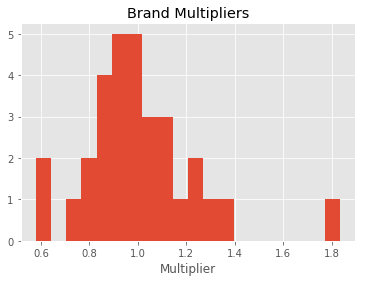

In [129]:
brand_mults = list(ind_results[1])
plt.hist(brand_mults, bins = 20)
plt.title('Brand Multipliers')
plt.xlabel('Multiplier')
plt.show()

We can see that the brand multipliers where generally normally distributed, with most of the mulitipliers between 0.7 and 1.4, with an outlier of 1.82, which was for the Bio brand. This indicates that organic food is more expensive by 1.8 times than the average non organi brand (not that this may have some bias with products that had organic versions being more expensive to begin with, but it did seem that there were Bio brands for many products). Other got almost 1, which makes sense as it was by far the most common brand, with a diverse range of products in it (both cheap and expensive) so it should be relativly neutral and dominating over others. The Lidl branded products were more expensive than average, while the Edeka and REWE branded where cheaper. Gut & Gunstig also appears to be a discount brand, as it had one of the lowest mutlipliers.

### Stores


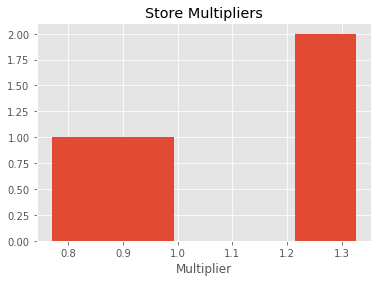

ALDI : 0.95
EDEKA : 1.33
Lidl : 0.77
REWE : 1.24


In [137]:
store_mults = list(ind_results[2])
plt.hist(store_mults, bins = 5)
plt.title('Store Multipliers')
plt.xlabel('Multiplier')
plt.show()

for j in range(len(ind_results[2])):
        print(full_names_list[2][j],":", round(ind_results[2][j],2))

From the store multipliers, we can see that Edeka and REWE were more expensive, with Aldi being cheaper and Lidl being the cheapest. This makes sense, as ALDI and Lidl are known as discount stores, while the other two are nicer. We can also see that the multipliers are each different, indicating that there was a difference between each of the stores that affected the store prices.

### Locations

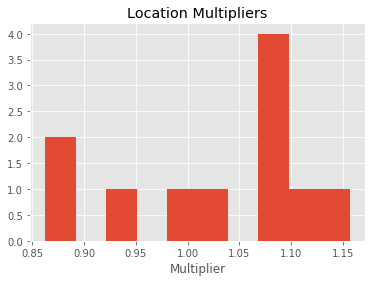

Alt-Treptow : 0.98
Cape Town : 0.93
Friedrichshain : 1.09
Kreuzberg : 1.1
Lichtenberg : 1.09
London : 1.01
Mitte : 1.1
Neukölln : 0.87
Prenzlauer Berg : 0.86
Schöneberg : 1.08
Tempelhof : 1.16


In [167]:
location_mults = list(ind_results[3])
plt.hist(location_mults, bins = 10)
plt.title('Location Multipliers')
plt.xlabel('Multiplier')
plt.show()

for j in range(len(ind_results[3])):
        print(full_names_list[3][j],":", round(ind_results[3][j],2))

From the store multipliers, we can see that there was less variation as a whole than with both brand and store. This initally indicates that while there is some variation, the store location has less of an impact on product prices than the brand of the product and the brand of the store. We can see that Cape Town was cheaper than the other neighborhoods, but there were only 2 stores from Capetown and thus we don't have much data from there and the result could easily be due to random fluctuation. We can also see that Tempelhof had the most expensive stores, while Prenzluare Berg and Neukölln had the cheapest stores.

## Rent Prices and Location

We can next look at the correlation between rent prices in each neighborhood and the price multiplier for that neighborhood. The rent prices were found by finding the most central station in each neighborhood and getting the rental price at that station from https://www.immobilienscout24.de/content/dam/is24/ibw/dokumente/mietmap-berlin-2017.jpg . 

In [92]:
# These rental prices were found by choosing
# the most central station in each 
# neighborhood and using the provided link
# to get the price

rental = { 'Alt-Treptow':794,
          'Friedrichshain':649,
          'Kreuzberg':863,
          'Lichtenberg':739,
          'Mitte':1044,
          'Neukölln':812,
          'Prenzlauer Berg':865,
          'Schöneberg':797,
          'Tempelhof':743}

rent_prices = [794,649,863,739,1044,812,865,797,743]

In [124]:
# Get the location multipliers
location_mults = list(ind_results[3])
#Remove the London and Cape Town multipliers
location_mults.pop(1)
location_mults.pop(5)

1.1034079481661021

In [125]:
location_mults

[0.98196240584582473,
 1.0853742594282989,
 1.0972067893099811,
 1.0924016943932848,
 1.0138009934276986,
 0.87094903218207398,
 0.86272088371994071,
 1.0781120877243575,
 1.1566326596892977]

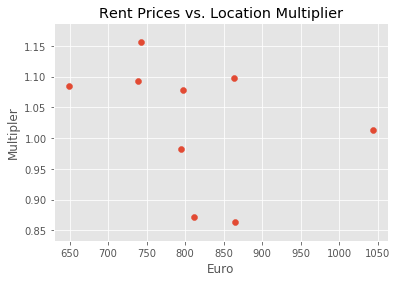

In [126]:
# Plot the correlation between Rent Prices and the Multiplier
plt.scatter(rent_prices,location_mults)
plt.title('Rent Prices vs. Location Multiplier')
plt.xlabel('Euro')
plt.ylabel('Multipler')
plt.show()

From the plot, we can see that there is no correlation between the rental prices in a neighborhood and the price multiplier from our model. This initially suggests that there is no correlation between rent prices and the price of groveries in that neighborhood. However, there were many simplifying assumptions that were made to make this model, namely grouping many grocery stores into larger neighborhoods and taking a rent price from a central place in the neighborhood. Not onyl that, but we have a rather small sample size, so I believe that further research is needed to determine if there is correlation between ent prices and the price of groceries.

# Appendix A

In [113]:
# This code segment was used to manually identify 
# which brands were most common and thus
# should be kept

# get a list of unique brands
np.unique(cleaned.brand)
occurs = {}
for name in np.unique(cleaned.brand):
    #the number of times it occurs
    occurs[name] = len(cleaned.where(cleaned.brand == name).dropna())

# print for manual inspection
for a in occurs:
    print(a,occurs[a])
    


 Kathi 1
 Tafelaepfel 1
 festkochend 1
 ideal reis langk.parb 1
- 1
6-er Bodenhaltung 1
Agata/Gala 2
Agricola 3
Akition 1
Aktion 1
AlNatura 1
Albert Bartlett potatoes 2
Alexandra 1
Alexandra potatoes 2
Alnatura 9
Alpenmilch 2
Alpenmilch  1
Alzu 1
Ambriosa 3
Ambrosia 3
Ambrosia Apfel Rot 1
Annabelle 1
Apfel 1
Apfel Evelina 1
Apfel Tenroy/Royal Gala 1
Apfel braeburn/ Etikett 1
Apfel pink lady lose 1
Apfel pink lady/ s.etikett 1
Apfel rot 1
Apfel rot Honeycrunch 1
Apfel rot lose 1
Apfel rot/ etikett 1
Aria 1
Arla 6
Arla Kaergarden 1
Aroma Tomaten 1
Aromatomaten 1
Aurora 13
Aurora pizzamehl 1
Aurora roggenmehl 1
Aus Bodenhaltung 1
Ayrshire 1
Baby Potatoes 1
Baerenmarke 3
Baerenmarke  2
Baking Potatoes 1
Balbake 1
Banana lose 1
Bananas 2
Bananen 4
Bananen Cose 1
Baren Marke 4
Baren Marke  1
Baren marke 2
Barenmark 1
Barenmarke 4
Barenmrke 1
Barther  Tomaten 1
Barther Gemüsegarten 3
Barther Strauchtomaten 1
Barther Tomaten 1
Bartlett 4
Basmati 8
Basmati Rice 1
Bauerbeste 2
Bauers Best 1
Baue